In [1]:
from err import err
from correlation import Correlation

# Importing Python modules
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import scipy
from scipy import signal
from scipy.signal import hilbert
from time import perf_counter, strftime, gmtime, sleep
import plotly.figure_factory as ff
from copy import deepcopy
import plotly.express as px
from loguru import logger
import os
import mat73
from bispectrum_real_data_analysis.scripts.utils import seconds_to_formatted_time
from plotly.subplots import make_subplots
from bispectrum_real_data_analysis.scripts.utils import standardize_array
import pendulum
from scipy import stats as st
import seaborn as sns
import re
import matplotlib 
from scipy.linalg import block_diag
from numpy.linalg import inv

fontsize = 15
matplotlib.rc('xtick', labelsize=fontsize) 
matplotlib.rc('ytick', labelsize=fontsize) 
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams.update({'font.size': fontsize})

%matplotlib inline

fig = 1

In [71]:
from scipy.io import savemat

### Importando os dados do arquivo din3.dat

In [2]:
group_number, rat_number = 5, 1

In [3]:
print(f"Group: {group_number}, Rat Number: {rat_number}")

Group: 5, Rat Number: 1


# Methods

In [4]:
# Method to extract events from dataframe

def select_event_window(
    df: pd.DataFrame, 
    event_name: str, 
    samples_before: int = 0, 
    samples_after: int = 0
) -> pd.DataFrame:
    """
    Method to extract the slice of the dataframe which contais the event, with some data before and after, 
    given number of samples to add to the begin and end, respectively.
    """

    window_index = np.argwhere(df.event.to_numpy() == event_name).flatten()
    begin_index = window_index[0] - samples_before
    end_index = window_index[-1] + samples_after
    return df[begin_index:end_index]

In [5]:
def decimate(data: pd.DataFrame, desired_frequency_sampling: float, filter: bool = False, time=None):
    if time is None:
        time = data.Time.to_numpy()
    TimeSampling = round(np.mean(time[1:] - time[:-1]), 6)
    FrequencySampling = 1.0/TimeSampling
    logger.info(f"The time sampling is {TimeSampling} seconds and the frequency is "
        f"{FrequencySampling/float(1000**(FrequencySampling<=1000))} {'k'*bool(FrequencySampling>=1000)}Hz")

    newTimeSampling = 1.0/desired_frequency_sampling
    decimation_rate = np.ceil(newTimeSampling/TimeSampling).astype(int)
    logger.info(f"The data will be decimated by the rate 1:{decimation_rate}")

    if filter:
        matrix = data.iloc[:, 1:-2].to_numpy()
        decimated_matrix = signal.decimate(matrix, decimation_rate, axis=0, ftype='fir', zero_phase=True)
        new_data = data.copy()[::decimation_rate]
        new_data.iloc[:, 1:-2] = decimated_matrix
    else:
        new_data = data[::decimation_rate]

    TimeSampling = TimeSampling*decimation_rate
    
    FrequencySampling = 1.0/TimeSampling
    logger.info(f"The new time sampling is {np.round(TimeSampling, 5)} s and the new frequency is "
    f"{FrequencySampling/float(1000**(FrequencySampling>=1000))} {'k'*bool(FrequencySampling>=1000)}Hz")
    
    return new_data, TimeSampling, FrequencySampling

In [6]:
def moving_average(x, N):
    return np.convolve(x, np.ones(N), 'same') / N

In [7]:
def get_events(data, threshold, window_size, time_sampling):
    
    x = data.CS_modulating.to_numpy()
    N = len(x)
    index = np.arange(N)
    plt.figure(figsize=(16,14))
    plt.subplot(321)
    plt.plot(index, x)
    plt.ylabel("x")

    x = x - np.mean(x[:10])
    plt.subplot(322)
    plt.plot(index, x)
    plt.ylabel("x - mean(x)")

    x = x**2
    plt.subplot(323)
    plt.plot(index, x)
    plt.ylabel("(x - mean(x))^2")

    x = moving_average(x, window_size)
    plt.subplot(324)
    plt.plot(index, x)
    plt.axhline(threshold, color="red", label="threshold")
    plt.legend(loc='upper right')
    plt.ylabel("moving_average_10_(x - mean(x))^2")

    x[x>threshold] = 1
    x[x<threshold] = 0

    plt.subplot(325)
    plt.plot(index, x)
    plt.ylabel("threshold(moving_average_10_(x - mean(x))^2)")

    indices = index[np.append(False, x[1:] - x[:-1]) != 0]

    for event, s, e in zip(range(1, 6), indices[0::2], indices[1::2]):
        print(f"\nEvent: {event}")
        print(f"start: {s}\nend: {e}") 
        print(f"time duration: {(e-s)*time_sampling}")

    print(f"\nlen(indices) = {len(indices)}")

    data = data.assign(event=np.empty(len(data), dtype=str))
    data.loc[:, "event"] = "base"

    for i, event in zip(range(0, len(indices), 2), np.arange(1, 6)):
        start = indices[i]
        end = indices[i+1]
        data.loc[start:end, "event"] = f"event_{event}"

    data.event.unique()

    plt.subplot(326)
    for event in data.event.unique():
        plt.plot(data.loc[data.event==event, "Time"], data.loc[data.event==event, "CS_modulating"], label=event)

    plt.ylabel("events")

    plt.show()
    return data

In [8]:
def AIC(n_theta, N, var_xi):
    """
    AIC(n_theta) = N ln[var(Xi(n_theta))] + 2 n_theta
    """
    return N*np.log(var_xi) + 2*n_theta

In [9]:
def MQ(Psi, y):
    theta = inv(Psi.T@Psi)@Psi.T@y
    residuos = y - Psi@theta
    return theta, residuos

## Algoritmo do estimador recursivo de Mínimos Quadrados Estendido (REMQ):

The algorithm calculates $\theta$ for each sample, and uses a crossvariance matrix to adjust the parameters, just like the Kalman filter does.

$$
\left\{
\begin{array}{l}
    K_k = P_{k-1} \psi_k \left[ \psi_k^T P_{k-1} \psi_k +1 \right]^{-1}; \\
    \mathbf{\hat{\theta}}_k = \mathbf{\hat{\theta}}_{k-1} + K_k \left[ y(k) - \psi_k^T \mathbf{\hat{\theta}}_{k-1}\right];\\
    P_k = P_{k-1} - K_k \psi_k^T P_{k-1};\\
    \xi(k) = y(k) - \psi_k^T \mathbf{\hat{\theta}}_k.
\end{array}
\right.
$$

In [10]:
def REMQ(u, y, numero_regressores=5, gain_P=10e6, all_thetas=True):
    P=np.eye(numero_regressores)*gain_P
    ini=2
    theta = np.empty(shape=(numero_regressores,len(u)))
    xi = np.zeros(len(u))
    theta[:,0] = np.zeros(numero_regressores)
    theta[:,1] = np.zeros(numero_regressores)
    # Algoritmo recursivo
    for k in range(ini,len(y)):
        # Calcula Psi(k)
        psi_k = np.vstack([y[k-1], y[k-2], u[k-1], u[k-2], xi[k-1]])
        # Calcula K(k)
        K_k = (P@psi_k)/(psi_k.T@P@psi_k+1)
        # Calcula Theta(k)
        theta[:,k] = theta[:,k-1] + K_k@(y[k]-psi_k.T@theta[:,k-1])
        # calcula P(k)
        P = P - K_k@psi_k.T@P
        xi[k] = y[k] - psi_k.T@theta[:,k]
    return theta if all_thetas else theta[:,-1]

# Loading files

In [37]:
# Loading and creating the data matrix

BASE_PATH = "/home/matheus/Documents/repositories/bispectrum_real_data_analysis/bispectrum_real_data_analysis/data/rats"    

logger.info(f"Loading .mat files for group {group_number} rat {rat_number}...")

data_train_filename = f"{BASE_PATH}/G{group_number}-R{rat_number}_PreTreino.mat"
data_test_filename = f"{BASE_PATH}/G{group_number}-R{rat_number}_Salina.mat"

raw_data_train = mat73.loadmat(data_train_filename)
raw_data_test = mat73.loadmat(data_test_filename)

logger.success("Creating data matrix...")

TimeSamplingTrain = 1.0/raw_data_train["srate"]
TimeSamplingTest = 1.0/raw_data_test["srate"]

N = raw_data_train["data"].shape[1]
M = raw_data_test["data"].shape[1]

timeTrain = np.arange(0, TimeSamplingTrain*N, TimeSamplingTrain)[:N]
timeTest = np.arange(0, TimeSamplingTest*M, TimeSamplingTest)[:M]

data_train = pd.DataFrame(
    {
        "Time": timeTrain,
        "CS_modulating": raw_data_train["data"][0],
        "Inferior_colliculus": raw_data_train["data"][1]
    }
) 

data_test = pd.DataFrame(
    {
        "Time": timeTest,
        "CS_modulating": raw_data_test["data"][0],
        "Inferior_colliculus": raw_data_test["data"][1]
    }
) 

logger.success("Done!")

2023-06-05 17:09:42.577 | INFO     | __main__:<module>:5 - Loading .mat files for group 5 rat 1...
2023-06-05 17:09:42.877 | SUCCESS  | __main__:<module>:13 - Creating data matrix...
2023-06-05 17:09:42.920 | SUCCESS  | __main__:<module>:40 - Done!


## Train data


Event: 1
start: 581533
end: 673143
time duration: 30.018764795081726

Event: 2
start: 856193
end: 947803
time duration: 30.018764795081726

Event: 3
start: 1222407
end: 1314017
time duration: 30.018764795081726

Event: 4
start: 1680174
end: 1771784
time duration: 30.018764795081726

Event: 5
start: 1954835
end: 2046445
time duration: 30.018764795081726

len(indices) = 10


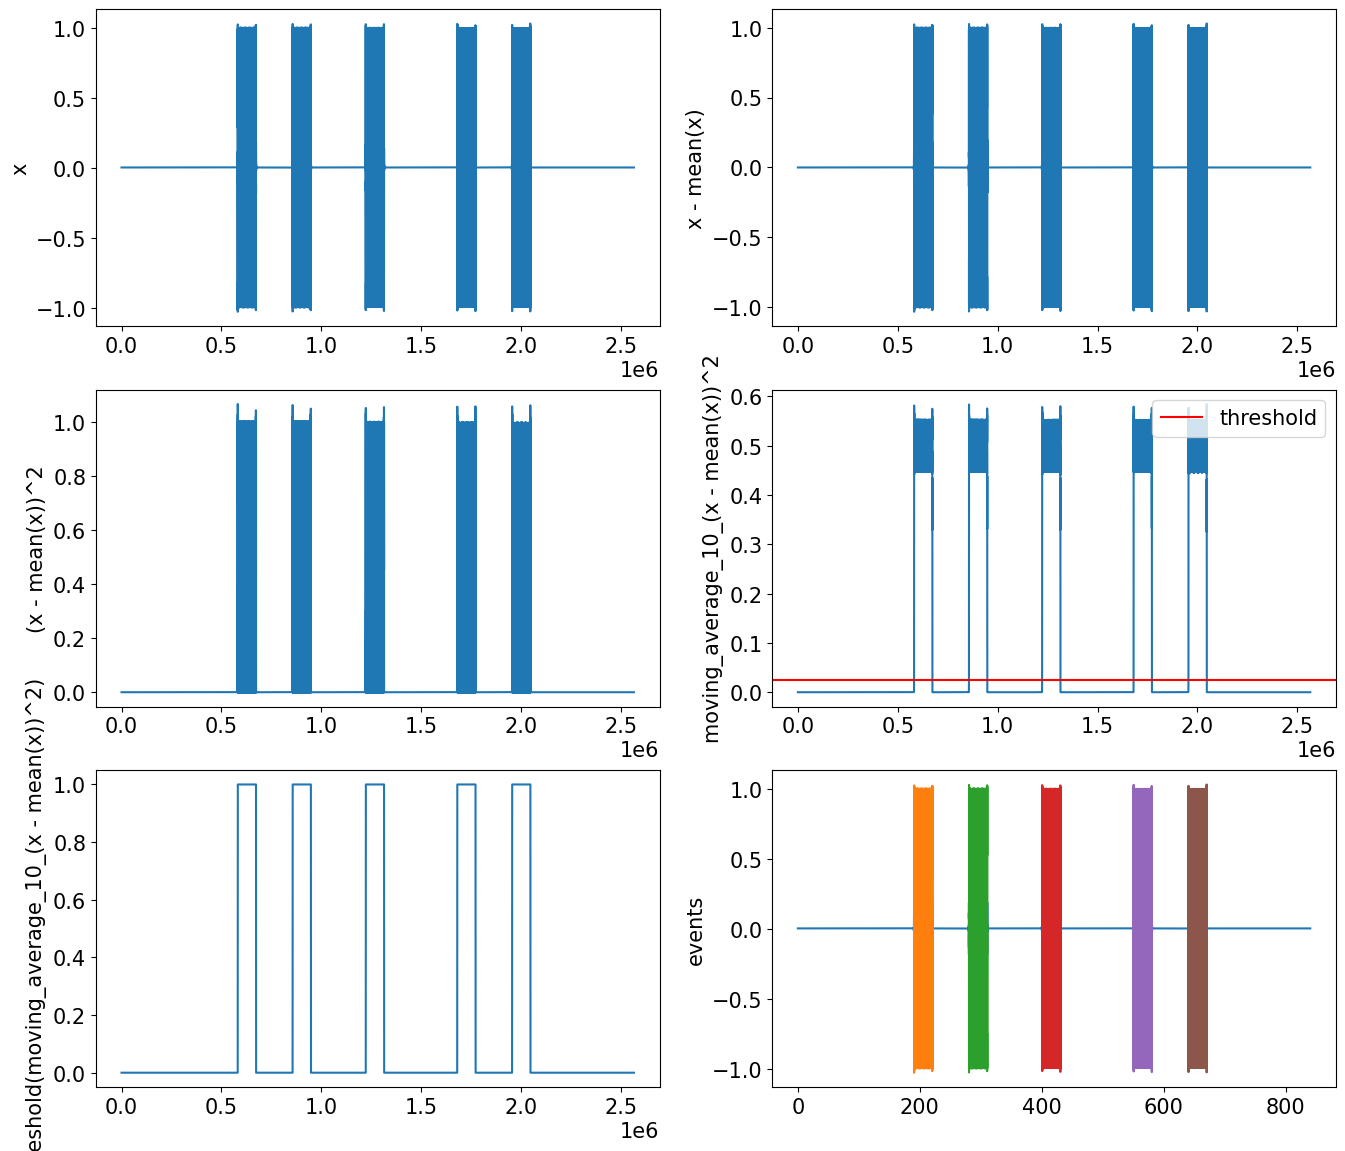

In [38]:
threshold = 0.025
window_size = 100

data_train = get_events(
    data=data_train, 
    threshold=threshold, 
    window_size=window_size, 
    time_sampling=TimeSamplingTrain
)

In [13]:
desired_frequency_sampling = 150

data_train, TimeSampling, FrequencySampling = decimate(data_train, desired_frequency_sampling=desired_frequency_sampling)

2023-06-05 17:01:52.415 | INFO     | __main__:decimate:6 - The time sampling is 0.000328 seconds and the frequency is 3048.780487804878 kHz
2023-06-05 17:01:52.416 | INFO     | __main__:decimate:11 - The data will be decimated by the rate 1:21
2023-06-05 17:01:52.417 | INFO     | __main__:decimate:24 - The new time sampling is 0.00689 s and the new frequency is 145.18002322880372 Hz


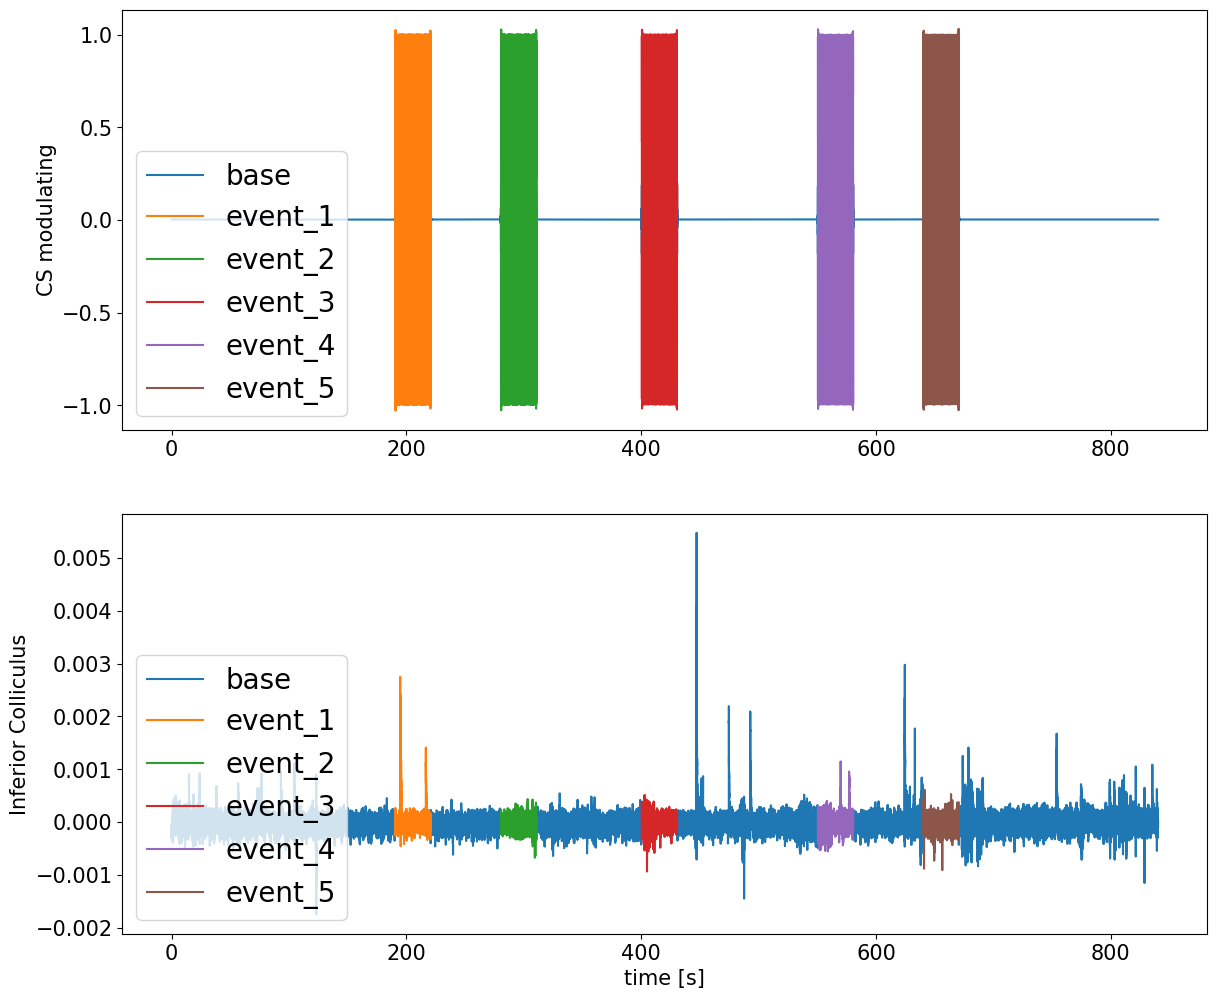

In [39]:
plt.figure(figsize=(14,12))

plt.subplot(211)
for event in data_train.event.unique():
    plt.plot(data_train.loc[data_train.event==event, "Time"], data_train.loc[data_train.event==event, "CS_modulating"], label=event)
plt.legend(loc='lower left', prop={'size': 20})
plt.ylabel("CS modulating")

plt.subplot(212)
for event in data_train.event.unique():
    plt.plot(data_train.loc[data_train.event==event, "Time"], data_train.loc[data_train.event==event, "Inferior_colliculus"], label=event)
plt.xlabel("time [s]")
plt.ylabel("Inferior Colliculus")
plt.legend(loc='lower left', prop={'size': 20})

plt.show()

## Test data


Event: 1
start: 581681
end: 673291
time duration: 30.018764795081726

Event: 2
start: 856342
end: 947952
time duration: 30.018764795081726

Event: 3
start: 1222556
end: 1314166
time duration: 30.018764795081726

Event: 4
start: 1680322
end: 1771933
time duration: 30.019092475081674

Event: 5
start: 1954983
end: 2046593
time duration: 30.018764795081726

len(indices) = 10


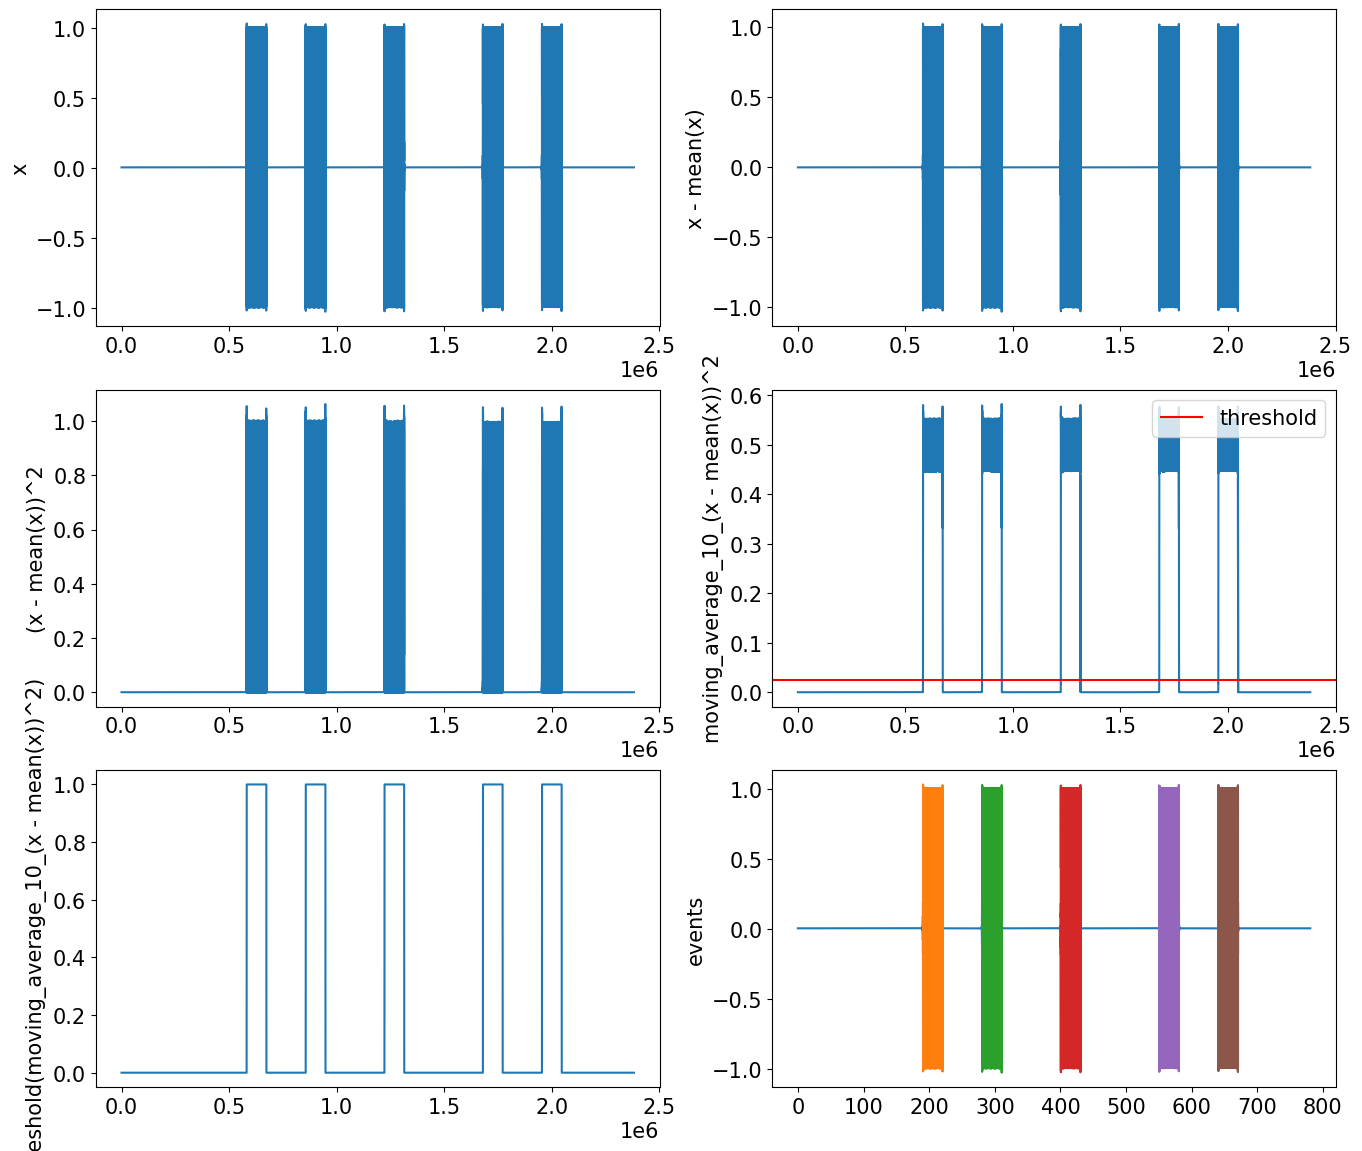

In [40]:
threshold = 0.025
window_size = 100

data_test = get_events(
    data=data_test, 
    threshold=threshold, 
    window_size=window_size, 
    time_sampling=TimeSamplingTest
)

In [16]:
data_test, TimeSampling, FrequencySampling = decimate(data_test, desired_frequency_sampling=desired_frequency_sampling)

2023-06-05 17:01:56.251 | INFO     | __main__:decimate:6 - The time sampling is 0.000328 seconds and the frequency is 3048.780487804878 kHz
2023-06-05 17:01:56.252 | INFO     | __main__:decimate:11 - The data will be decimated by the rate 1:21
2023-06-05 17:01:56.252 | INFO     | __main__:decimate:24 - The new time sampling is 0.00689 s and the new frequency is 145.18002322880372 Hz


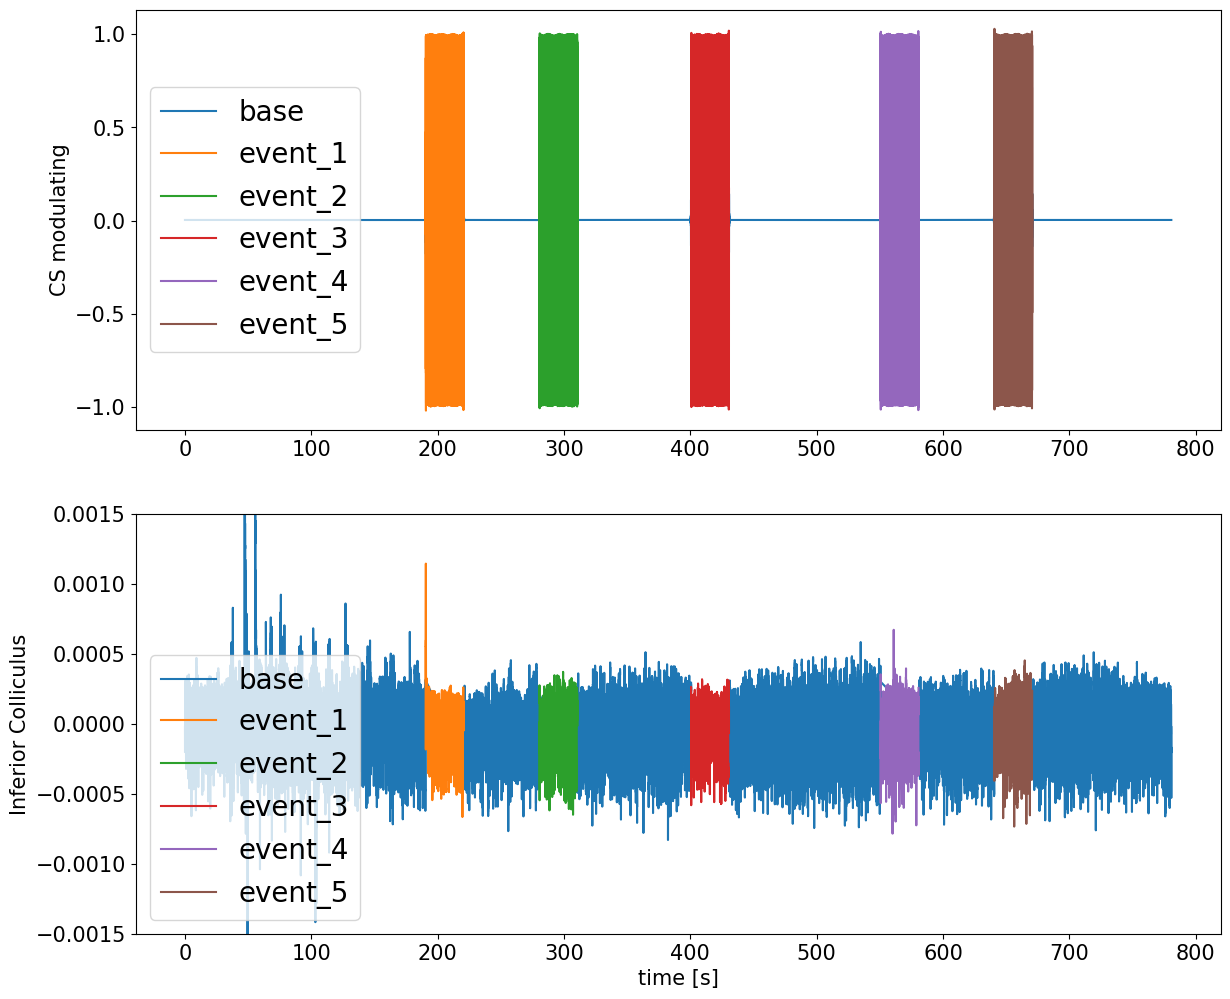

In [17]:
plt.figure(figsize=(14,12))

plt.subplot(211)
for event in data_train.event.unique():
    plt.plot(data_test.loc[data_test.event==event, "Time"], data_test.loc[data_test.event==event, "CS_modulating"], label=event)
plt.legend(loc=6, prop={'size': 20})
plt.ylabel("CS modulating")

plt.subplot(212)
for event in data_test.event.unique():
    plt.plot(data_test.loc[data_test.event==event, "Time"], data_test.loc[data_test.event==event, "Inferior_colliculus"], label=event)
plt.xlabel("time [s]")
plt.ylabel("Inferior Colliculus")
plt.legend(prop={'size': 20})
plt.ylim([-1.5e-3, 1.5e-3])
plt.savefig(
    "test_waveform.jpg",
    format="jpg",
    bbox_inches='tight', 
    dpi=150
)
plt.show()

### Obtendo o resultado do Critério de Redução de Erro 

In [41]:
data = data_test

In [52]:
event_number = 1

event_data = select_event_window(
    df=data, 
    event_name=f"event_{event_number}", 
    samples_before=0, 
    samples_after=0
)

y = event_data.Inferior_colliculus.to_numpy()

y = (y - y.min())/(y.max()-y.min())
y -= y.mean()
u = event_data.CS_modulating.to_numpy()

In [53]:
time = event_data.Time.to_numpy()

In [63]:
time.shape

(91610,)

In [64]:
time[0]

190.60523004877123

In [65]:
time[-1]

220.623667163853

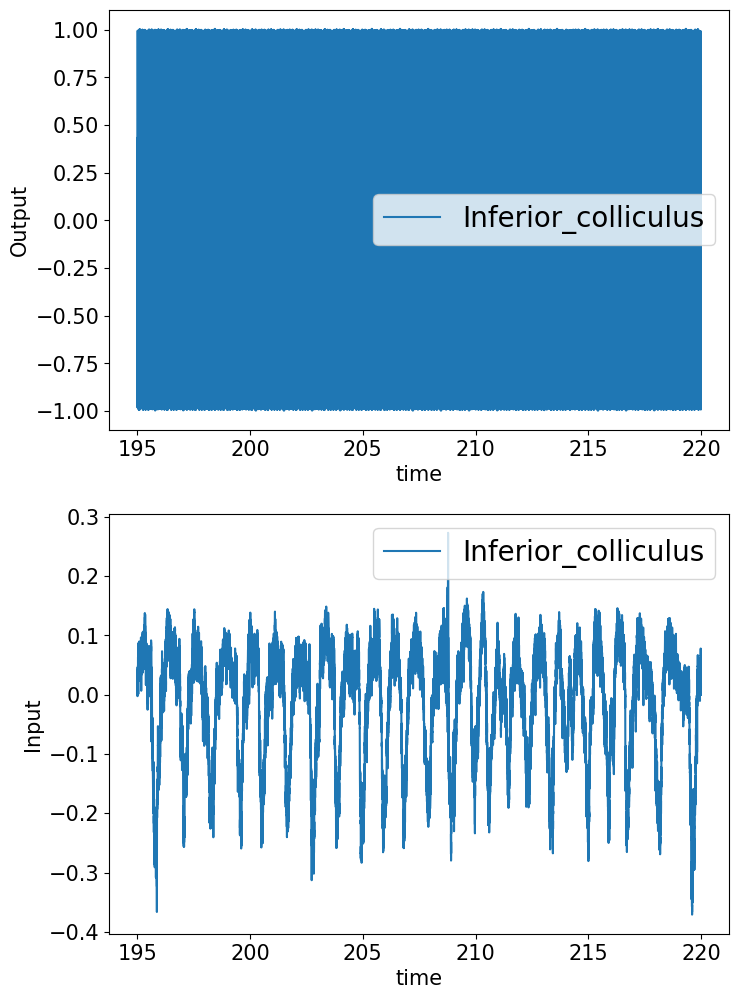

In [67]:
plt.figure(figsize=(8,12))

start = 195
threshold = 220

time_to_plot = time[(time>start)&(time<threshold)]

plt.subplot(212)
plt.plot(time_to_plot, y[(time>start)&(time<threshold)],label="Inferior_colliculus")
plt.xlabel("time")
plt.ylabel("Input")
plt.legend(prop={'size': 20})

plt.subplot(211)

plt.plot(time_to_plot, u[(time>start)&(time<threshold)],label="Inferior_colliculus")
plt.xlabel("time")
plt.ylabel("Output")
plt.legend(prop={'size': 20})

plt.show()

In [68]:
time_mazoni = time[(time>start)&(time<threshold)]
ic_mazoni = y[(time>start)&(time<threshold)]
cs_mazoni = u[(time>start)&(time<threshold)]

In [70]:
df = pd.DataFrame(
    {
        "time": time_mazoni,
        "ic": ic_mazoni,
        "cs": cs_mazoni
    }
)



In [75]:
df.to_csv("group5rat1event1.csv")

In [73]:
savemat(
    "group5rat1event1.mat",
    df.to_dict()
)

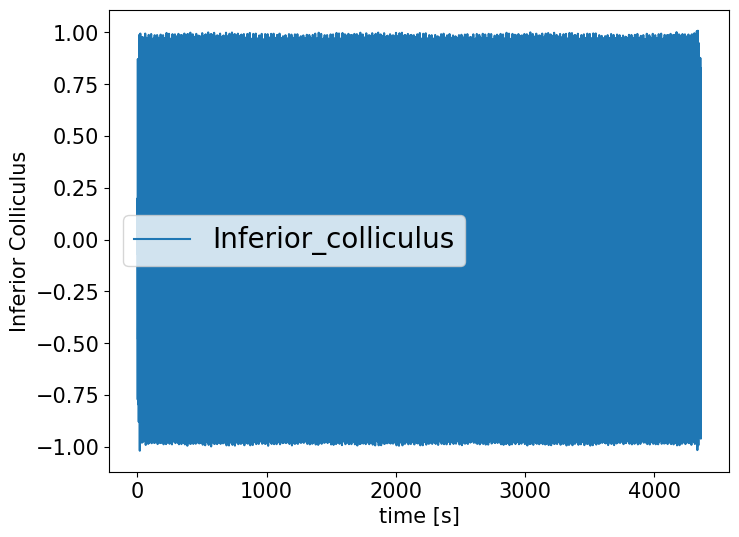

In [26]:
plt.figure(figsize=(8,6))



plt.show()

In [65]:
degree_of_non_linearity: int = 4
max_y_delays: int = 4
max_u_delays: int = 4

max_delays = max(max_y_delays, max_u_delays)

err_obj = err(
    ny=max_y_delays,
    nu=max_u_delays,
    n_lin=degree_of_non_linearity,
    yid=y,
    uid=u,
    cte=True
)

start_time = perf_counter()

err_out, termos, psi = err_obj.run(print_result=True)

end_time = perf_counter()

2023-05-25 23:40:04.007 | INFO     | err:__termos:71 - Creating Terms
2023-05-25 23:40:04.009 | INFO     | err:__regressores:140 - Creating regressors - psi matrix
2023-05-25 23:40:04.066 | INFO     | err:__err:162 - Calculating ERR
100% (495 of 495) |######################| Elapsed Time: 0:45:35 ETA:  00:00:002023-05-26 00:25:39.308 | SUCCESS  | err:run:314 - Done. ERR method finished.


     ordem         valor
0        1  9.328143e-01
1        8  8.566226e-03
2        3  2.262932e-03
3      339  8.183854e-04
4      110  6.434208e-04
..     ...           ...
490    399  1.012285e-06
491    372  3.060812e-07
492     34  1.923218e-07
493    324  1.459346e-07
494    175  2.827671e-08

[495 rows x 2 columns]


### Obtendo o Critério de Informação de Akaike para a matriz $\Psi$ gerada pelo ERR

In [53]:
def eval_model_SISO_NARX(
    model: list[str] | np.ndarray[str],
    theta: list[float|int] | np.ndarray[float|int],
    u: list[float|int] | np.ndarray[float|int],
    y0: int | float | list[float|int] | np.ndarray[float|int]
) -> np.ndarray[float]:
    """ Method to evaluate model using free simulation.
    The model must contain 'u' as input, 'y' as output and must be parsable using eval.
    
    returns (np.ndarray[float]): output of free simulation
    """
    y = np.zeros(len(u))
    y0 = y0 if isinstance(y0, np.ndarray) or isinstance(y0, list) else np.array([y0])
    y[:len(y0)] = y0
   
    for k in range(len(y0),len(u)):
        for gain, term in zip(theta, model):
            y[k] += gain*eval(term)
            
    return y

In [55]:
def NARX(u, theta, y0=None):
    y = np.zeros(len(u))
    if y0 is not None:
        y0 = y0 if isinstance(y0, np.ndarray) else np.array([y0])
        y[:len(y0)] = y0
    else:
        y0 = [0]
    for k in range(len(y0),len(u)):
        y[k] =  (
            theta[0] * y[k-1] 
          + theta[1] * (u[k-1]*u[k-2])
          + theta[2] * y[k-2]
          + theta[3] * u[k-2]
          + theta[4] * np.power(u[k-3], 2)
          + theta[4] * np.power(u[k-1], 2)
        )
    return y

In [ ]:
Phi = np.array([])

aic = np.array([])
parameters = np.array([])

for i in range(len(psi.T)):
    
    if i == 0:
        Phi = psi[:,err_out["ordem"][i]][None]
    else:
        Phi = np.vstack([Phi, psi[:,err_out["ordem"][i]]])  
            
    thetaMQ, residuos = MQ(Phi.T, y[max_y_delays:])
    
    var_xi = np.var(residuos)
    
    n_theta = len(thetaMQ)
    
    aic = np.append(aic, AIC(n_theta, len(y), var_xi))
    
    parameters = np.append(parameters, i+1)

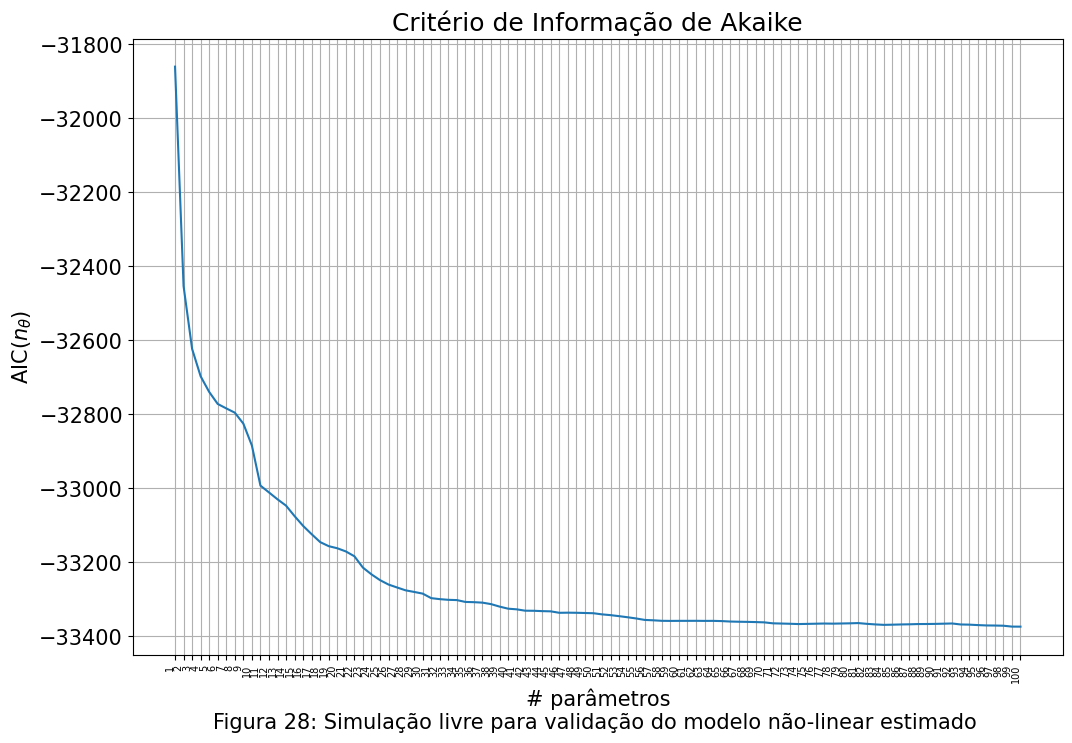

In [82]:
max_number_of_parameters = 100  # float("Inf")
plt.plot(parameters[parameters<=max_number_of_parameters], aic[parameters<=max_number_of_parameters])
plt.title("Critério de Informação de Akaike")
xlabel = "# parâmetros"
caption = f"Figura {fig}: Simulação livre para validação do modelo não-linear estimado "; fig +=1
plt.xlabel(xlabel+"\n"+caption)
plt.ylabel("AIC($n_{\\theta}$)")
plt.xticks(parameters[parameters<=max_number_of_parameters], rotation=90, ha='right', fontsize=7)
plt.grid()
plt.show()

Considerando o Critério de Informação de Akaike, são escolhidos os 5 primeiros regressores listados, que consistem das combinações de número 1, 14, 7, 2 e 5, da tabela de termos mostrada abaixo:

In [99]:
number_of_selected_terms = 100

In [100]:
psi_mq = np.vstack([psi[:,i] for i in err_out["ordem"][:number_of_selected_terms]]).T

theta, xi = MQ(psi_mq, y[max_y_delays:])

print(f"Theta ordenado: {theta}")

Theta ordenado: [ 8.59354999e-01  1.43463634e-02  1.17712801e-01 -8.51013984e-03
  2.05446090e+01 -2.61112301e-02 -3.49738216e-02 -2.33313354e+01
 -1.57385215e+01  4.26213073e+01  4.48824080e+01 -5.17847137e+00
  1.24334608e+01 -1.83506630e+01 -1.25657860e+00  5.90068242e+00
 -2.51174137e+00  6.79921561e+00  1.14886102e-01  2.29824551e-02
 -7.32346300e-03  1.04184577e+01  1.35845781e+00 -6.91602413e-01
  2.06141327e+01  1.14417493e+01 -2.15095057e+01 -4.18115843e+01
  1.09779636e+02 -4.03781596e+00 -5.55448854e+00 -8.45288699e+00
  7.97848444e-01 -1.78889464e-01  1.76635118e-01 -4.16998717e+01
  3.95535488e+01  4.73463455e+00 -2.04448190e+02  3.23285625e+01
 -1.39330349e-01  7.65669552e-02  1.62342960e-02 -1.42866877e+00
  6.39004470e+01  4.86084656e+00 -3.93918380e+00 -6.68778743e-01
  3.83102366e+00 -5.92586375e+01  1.18876413e+02  3.44609908e+00
  7.19850838e+00 -1.61842931e+00  9.80913048e-01  1.00058165e+01
  7.14431092e-03  2.78935149e-02 -2.05628771e+01 -2.47989467e+00
 -6.55100

Assim, o modelo NARX escolhido é:

In [106]:
terms_dict = termos.iloc[err_out["ordem"][:number_of_selected_terms]].T.to_dict()

model = []
model_dict = {}

for reg_number, line in terms_dict.items():
    term = ""
    for reg, power in line.items():
        term += " * " if term and power else ""
        term += reg if power > 0 else ""
        term += f"**{int(power)}" if power > 1 else ""
    term += "1"*(not bool(term))
    term = term.replace("(", "[").replace(")", "]")
    model.append(term)
    model_dict[reg_number] = term
    
print("\n\nTermos:\n")

for line, term in model_dict.items():
    print(f"{line}: {term}")
    
terms_per_line = 4
print("\ny(k) = ", end="")
for i, term in enumerate(model, start=1):
    print(f"{term}{' + '*(i not in (len(model),))}", end="\n" if not i % terms_per_line else "")
    
print("\n\n\n")



Termos:

1: y[k-1]
8: u[k-4]
3: y[k-3]
339: u[k-2] * u[k-3]**2 * u[k-4]
110: y[k-1] * y[k-2] * y[k-4]
6: u[k-2]
5: u[k-1]
186: y[k-1]**2 * y[k-4] * u[k-3]
182: y[k-1]**2 * y[k-3] * u[k-3]
428: y[k-1] * y[k-2] * y[k-3] * u[k-3]
432: y[k-1] * y[k-2] * y[k-4] * u[k-3]
47: y[k-1]**2 * y[k-4]
218: y[k-1] * y[k-4]**2 * u[k-3]
209: y[k-1] * y[k-3]**2 * u[k-3]
198: y[k-1] * y[k-2]**2 * u[k-3]
398: y[k-3]**3 * u[k-3]
407: y[k-4]**3 * u[k-3]
293: y[k-3] * y[k-4]**2 * u[k-3]
2: y[k-2]
330: u[k-1]**2 * u[k-2] * u[k-4]
85: y[k-4] * u[k-1]**2
344: y[k-1]**2 * u[k-1]**2
40: y[k-4]**2
346: y[k-1]**2 * u[k-3]**2
165: y[k-1]**4
352: y[k-2]**2 * u[k-3]**2
168: y[k-4]**4
52: y[k-1] * y[k-2]**2
343: y[k-1]**2 * y[k-4]**2
202: y[k-1] * y[k-2] * u[k-1]**2
350: y[k-2]**2 * u[k-1]**2
102: y[k-2]**3
49: y[k-1]**2 * u[k-2]
479: y[k-2] * u[k-2] * u[k-3] * u[k-4]
489: y[k-3] * u[k-2] * u[k-3] * u[k-4]
177: y[k-1]**2 * y[k-2] * u[k-3]
59: y[k-2]**2 * y[k-3]
39: y[k-3]**2
179: y[k-1]**2 * y[k-3] * y[k-4]
200: y[k-

Validação utilizando a segunda metade da massa de dados:

In [102]:
y_free = eval_model_SISO_NARX(
    model=model, 
    theta=theta, 
    u=u, 
    y0=np.zeros(max_delays)
)

Carregando a saída da validação e os resíduos de estimação do modelo cuja estrutura foi obtida no Livro-texto, na Lista de Exercícios 9 

#### Plotando as curvas de validação

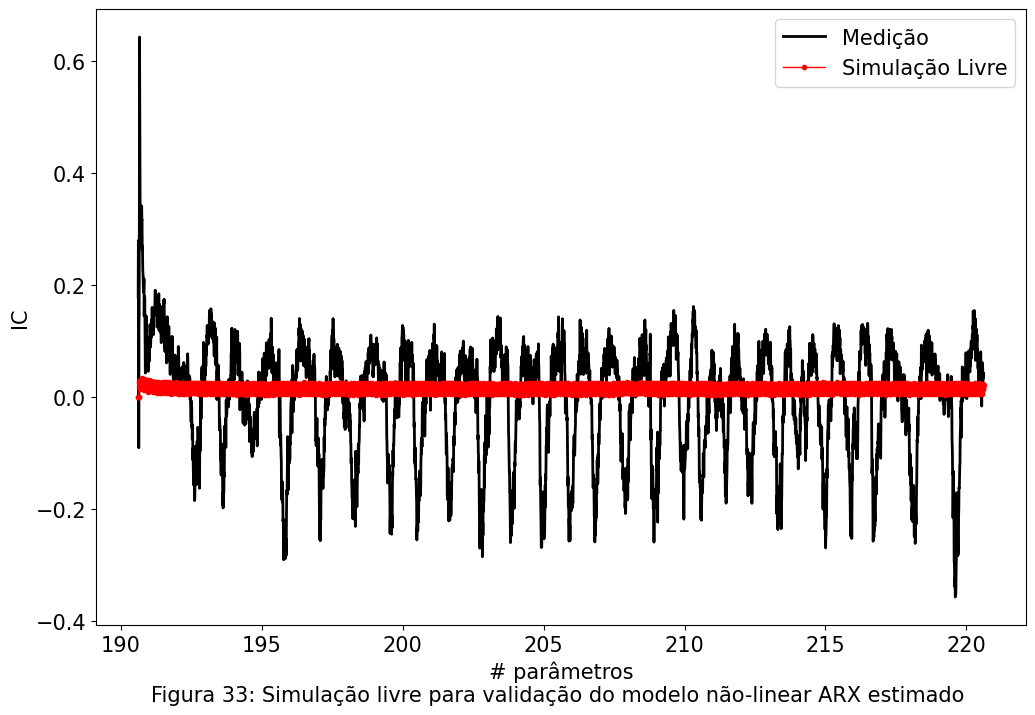

In [103]:
y_validacao = y_free
time = event_data.Time.to_numpy()

plt.figure()
plt.plot(time, y, linewidth=2, label="Medição", color='black')
plt.plot(time, y_validacao ,marker='.',color = 'red', linewidth=1, label="Simulação Livre")
plt.legend()
plt.ylabel("IC")
caption = f"Figura {fig}: Simulação livre para validação do modelo não-linear ARX estimado "; fig +=1
plt.xlabel(xlabel+"\n"+caption)

plt.show()

Ambos os modelos apresentaram curvas estáticas similares e não serão apresentadas neste trabalho por já constarem nas listas de Exercícios anteriores.

#### Cálculo do RMSD

In [104]:
# Método para calcular o desvio RMS (RMSD)
def RMSD(y, y0):
    error = y-y0
    error = np.square(error)
    error = np.sum(error)
    error = error/len(y)
    error = np.sqrt(error)
    return error

In [105]:
rmsd = RMSD(y, y_validacao)

print(f"RMSD Modelo Estimado ({len(theta)} parâmetros): {np.round(rmsd, 5)}")

RMSD Modelo Estimado (100 parâmetros): 0.1013


#### Análise de residuos do modelo estimado: $r_\xi(\tau)$, $r_{\xi^2}(\tau)$, $r_{\xi \xi^2}(\tau)$  e $r_{u \xi} (\tau)$:

#### $r_\xi(\tau)$

In [ ]:
x_axis, ryy, c = Correlation.correlate(x1=xi, x2=xi, size_output=40, bilateral=True, norm=True)

Correlation.plot_correlation(x_axis=x_axis,
                             cross_correlation=ryy,
                             confidence=c,
                             labelcorrelation="$r_{\\xi}$",
                             title="Auto Correlação $\\xi$",
                             caption=f"Figura {fig}: Auto Correlação $\\xi$",
                             xlabel='atrasos'); fig += 1


#### $r_{\xi^2}(\tau)$

In [ ]:
x_axis, ryy, c = Correlation.correlate(x1=np.power(xi, 2), x2=np.power(xi, 2), size_output=40, bilateral=True, norm=True)

Correlation.plot_correlation(x_axis=x_axis,
                             cross_correlation=ryy,
                             confidence=c,
                             labelcorrelation="$r_{\\xi^2}$",
                             title="Auto Correlação $\\xi^2$",
                             caption=f"Figura {fig}: Auto Correlação $\\xi^2$",
                             xlabel='atrasos'); fig += 1


#### $r_{\xi \xi^2}(\tau)$ 

In [ ]:
x_axis, ryy, c = Correlation.correlate(x1=xi, x2=np.power(xi, 2), size_output=40, bilateral=True, norm=True)

Correlation.plot_correlation(x_axis=x_axis,
                             cross_correlation=ryy,
                             confidence=c,
                             labelcorrelation="$r_{\\xi \\xi^2}$",
                             title="Correlação Cruzada $\\xi \\xi^2$",
                             caption=f"Figura {fig}: Correlação Cruzada $\\xi \\xi^2$",
                             xlabel='atrasos'); fig += 1


#### $r_{u \xi} (\tau)$:

In [ ]:
x_axis, ryy, c = Correlation.correlate(x1=u_1, x2=xi, size_output=40, bilateral=True, norm=True)

Correlation.plot_correlation(x_axis=x_axis,
                             cross_correlation=ryy,
                             confidence=c,
                             labelcorrelation="$r_{u \\xi}$",
                             title="Correlação Cruzada $u \\xi$",
                             caption=f"Figura {fig}: Correlação Cruzada $y_a(k)$",
                             xlabel='atrasos'); fig += 1


#### Análise de resíduos: Modelo estimado

Os resíduos não são brancos em nenhum dos testes feitos, o que significa que estatísticamente, o modelo não explica toda "informação determinística" contida nos sinais de estimação. Há auto-correlação linear e não-linear nos resíduos, além de correlação cruzada entre os resíduos e a entrada.

Porém, pode ser observado que embora as correlações sejam não desprezíveis, elas não afetam de forma considerável a qualidade do modelo, visto que a validação com a metade dos dados complementar à parte usada na estimação foi satisfatória. 

Para que o modelo fique estatísticamente "sadio", regressores lineares e não lineares deveriam ser adicionados para que essas correlações apresentadas pudessem ser explicadas por eles, porém, como a validação foi satisfatória, não se julgou necessário realizar essa etapa de melhoria no modelo.

#### Análise de residuos do modelo do Livro-texto: $r_\xi(\tau)$, $r_{\xi^2}(\tau)$, $r_{\xi \xi^2}(\tau)$  e $r_{u \xi} (\tau)$:

O modelo obtido na Lista 9 foi:

Modelo não linear (Equação 16.23 do Livro-texto):

$$
\begin{split}
y(k) &=& \theta_1 y(k-1) + \theta_2 u(k-2) u(k-1) + \theta_3 u(k-1)^2 + \theta_4 y(k-2) \\ &&+ \theta_5 u(k-2) y(k-1) + \theta_6 u(k-2) y(k-2) + \theta_7 u(k-2)^2 \\ &&+ \sum_{i=8}^{13} \hat{\theta}_i \xi (k-i) + \xi(k)
\end{split}
$$

Com $\mathbf{\hat{\theta}} =  \left[\begin{array}{c}1.29842954\\ 0.01015082\\ 0.04124637\\ -0.38208772\\ -0.14799786\\ 0.11159848\\ 0.00494685\\  0.08174968\\ -0.13740357\\  0.12312015\\ -0.24861337\\  0.1605504 \end{array}\right]$

#### $r_\xi(\tau)$

In [ ]:
x_axis, ryy, c = Correlation.correlate(x1=residuo_modelo_livro, x2=residuo_modelo_livro, size_output=40, bilateral=True, norm=True)

Correlation.plot_correlation(x_axis=x_axis,
                             cross_correlation=ryy,
                             confidence=c,
                             labelcorrelation="$r_{\\xi}$",
                             title="Auto Correlação $\\xi$",
                             caption=f"Figura {fig}: Auto Correlação $\\xi$",
                             xlabel='atrasos'); fig += 1


#### $r_{\xi^2}(\tau)$

In [ ]:
x_axis, ryy, c = Correlation.correlate(x1=np.power(residuo_modelo_livro, 2), x2=np.power(residuo_modelo_livro, 2), size_output=40, bilateral=True, norm=True)

Correlation.plot_correlation(x_axis=x_axis,
                             cross_correlation=ryy,
                             confidence=c,
                             labelcorrelation="$r_{\\xi^2}$",
                             title="Auto Correlação $\\xi^2$",
                             caption=f"Figura {fig}: Auto Correlação $\\xi^2$",
                             xlabel='atrasos'); fig += 1


#### $r_{\xi \xi^2}(\tau)$ 

In [ ]:
x_axis, ryy, c = Correlation.correlate(x1=residuo_modelo_livro, x2=np.power(residuo_modelo_livro, 2), size_output=40, bilateral=True, norm=True)

Correlation.plot_correlation(x_axis=x_axis,
                             cross_correlation=ryy,
                             confidence=c,
                             labelcorrelation="$r_{\\xi \\xi^2}$",
                             title="Correlação Cruzada $\\xi \\xi^2$",
                             caption=f"Figura {fig}: Correlação Cruzada $\\xi \\xi^2$",
                             xlabel='atrasos'); fig += 1


#### $r_{u \xi} (\tau)$:

In [ ]:
x_axis, ryy, c = Correlation.correlate(x1=u_1, x2=residuo_modelo_livro, size_output=40, bilateral=True, norm=True)

Correlation.plot_correlation(x_axis=x_axis,
                             cross_correlation=ryy,
                             confidence=c,
                             labelcorrelation="$r_{u \\xi}$",
                             title="Correlação Cruzada $u \\xi$",
                             caption=f"Figura {fig}: Correlação Cruzada $u \\xi$",
                             xlabel='atrasos'); fig += 1


#### Análise de Resíduos: Modelo não-linear do Livro Texto


O desempenho estatístico do modelo apresentado no livro é superior ao modelo estimado por dois motivos:

* O modelo possui dois parâmetros a mais;
* O estimador utilizado foi o Mínimos Quadrados Estendido, logo, cinco regressores de resíduos foram modelados, assumindo que o ruído não era branco, assim, caso haja polarização neste caso, ela provavelmente é menor do que a polarização do modelo NARX estimado, que possui apenas cinco parâmetros.

Ainda sim, aparecem correlações em todos os casos, porém, a autocorrelação linear dos resíduos é quase impulsiva, demonstrando que grande parte das correlações lineares dos sinais de estimação foram explicadas pelo modelo.

Estatíticamente, o modelo apresentado pelo Livro-texto é melhor, tal como seu RMSD é menor que o RMSD do modelo estimado, porém, o modelo é menos "parcimonioso", por modelar 5 termos de resíduos e possuir sete parâmetros realtivos aos regressores e de $y(k)$ e $u(k)$. Portanto, sugere-se a escolha do modelo estimado em situações que o desempenho estatístico não é a métrica de qualidade principal.

Cálculo do Erro de Sincronização Máximo Normalizado e do Custo de Sincronização:

In [ ]:
def error_sync(c, xi):
    e = np.zeros(len(xi))
    for k in range(1, len(xi)):
        e[k] = c*e[k-1] + xi[k-1]
    return e

In [ ]:
def Jrms(N, k0, h):
    return np.sqrt((1/(N-k0+1))*(c*np.sum(np.power(h, 2)[k0:N])))

In [ ]:
def epsilon(e):
    
    def norm(x):
        return (x-np.min(x))/np.linalg.norm(x-np.min(x))
    
    num = np.max(norm(e))
    den = num + 1
    return num/den

In [ ]:
c_vec = np.arange(0.01, 0.99, 0.01)

e_vec_modelo_livro = np.zeros((len(c_vec),len(residuo_modelo_livro)))
e_vec_modelo_estimado = np.zeros((len(c_vec),len(xi)))


for k, c in enumerate(c_vec):
    e_vec_modelo_livro[k] = error_sync(c, residuo_modelo_livro)
    e_vec_modelo_estimado[k] = error_sync(c, xi)

epsilon_vec_modelo_livro = np.zeros(len(c_vec))
epsilon_vec_modelo_estimado = np.zeros(len(c_vec))

for k in range(len(c_vec)):
    epsilon_vec_modelo_livro[k] = epsilon(e_vec_modelo_livro[k])
    epsilon_vec_modelo_estimado[k] = epsilon(e_vec_modelo_estimado[k])
    
J_modelo_estimado = np.zeros(len(e_vec_modelo_estimado))
J_modelo_livro = np.zeros(len(e_vec_modelo_livro))

for k, c in enumerate(c_vec):
    J_modelo_estimado[k] = Jrms(N=len(xi), k0=0, h=c*e_vec_modelo_estimado[k])
    J_modelo_livro[k] = Jrms(N=len(residuo_modelo_livro), k0=0, h=c*e_vec_modelo_livro[k])
    
plt.figure()
plt.plot(c_vec, epsilon_vec_modelo_livro, label='modelo livro')
plt.plot(c_vec, epsilon_vec_modelo_estimado, label='modelo estimado')
plt.title('Erro de Sincronização Máximo Normalizado')
plt.legend()
plt.ylabel("$\epsilon_{m}$")
caption = f"Figura {fig}: Erro de Sincronização Máximo Normalizado"; fig +=1
xlabel = 'c'
plt.xlabel(xlabel+"\n"+caption)

plt.figure()
plt.plot(c_vec, J_modelo_livro, label='modelo livro')
plt.plot(c_vec, J_modelo_estimado, label='modelo estimado')
plt.title('Custo de Sincronização')
plt.legend()
plt.ylabel("$J_{rms}$")
caption = f"Figura {fig}: Custo de Sincronização"; fig +=1
plt.xlabel(xlabel+"\n"+caption)

plt.show()

Análise de Resíduos do modelo do Livro-texto (com 7 parâmetros, Lista de Exercícios 9), para comparar com a análise de resíduos do modelo estimado na Lista de Exercícios 10 (acima)

Considerações:

Os modelos não-lineares apresentaram resultados satisfatórios visualmente. O modelo estimado possui um RMSD (*root mean square deviation*) igual a 0.00578, que é maior do que o RMSD do modelo não-linear apresentado no livro, cujo valor é 0.0055. Vale ressaltar que o modelo não-linear apresentado no livro possui sete parâmetros, em comparação com o modelo estimado neste trabalho, que possui apenas cinco, ou seja, essa redução no RMSD teve um custo de aumentar a complexidade do modelo adicionando dois parâmetros não lineares. 

O erro de sincronização máximo normalizado do modelo apresentado no Livro-texto é maior do que o erro do modelo estimado para $0 < c \leq 0,7$ e a para $c > 0,9$ é menor. Já o custo de sincronização de ambos começa similar, para $c>0,3$ o custo de sincronização do modelo estimado é levemente maior e para $c>0,9$ o cenário se inverte.

Dinamicamente, o modelo do Livro-texto é melhor, para um valor de $c \approx 0,98$, onde ocorre o mínimo erro máximo normalizado, visto que o custo de sincronização dos modelos é próximo neste ponto.

# Exercícios 2.

Use os dados boxjenk.dat. Siga tantos passos quanto puder (dos que foram apresentados ao longo do curso) para identificar modelos. Discuta, fundamentado no uso das ferramentas descritas ao longo do curso, questões tais como: tempo de amostragem, adequabilidade de representar essa relação com modelos lineares, escolha da estrutura do modelo, validação, variância temporal do processo etc.

In [ ]:
# Carrega arquivo (arquivo precisa estar no mesmo folder que o notebook)
filename1 = 'boxjenk.dat'
data = np.loadtxt(filename1)
# Separa os dados do arquivo em duas variáveis
u = data[:,0]
y = data[:,1]

plt.figure()
plt.plot(u, label="u(k)")
plt.legend()
plt.title("Entrada boxjenk.dat")
plt.ylabel("u(k)")
xlabel = 'k'
caption = f"Figura {fig}: Entrada do arquivo de dados boxjenk.dat"; fig +=1
plt.xlabel(xlabel+"\n"+caption)

plt.figure()
plt.plot(y, label="y(k)")
plt.legend()
plt.title("Saída boxjenk.dat")
xlabel = 'k'
plt.ylabel("y(k)")
caption = f"Figura {fig}: Saída do arquivo de dados boxjenk.dat"; fig +=1
plt.xlabel(xlabel+"\n"+caption)

plt.show()

Para determinar qual sinal era a entrada e qual sinal era a saída, foi utilizada a correlação cruzada. 

Primeiro, foi feita a correlação cruzada de um sinal de entrada e um sinal de saída de um modelo ARX sem ruído, para observar o comportamento da função em casos de correlação entre os sinais. Foi determinado que o gráfico de correlação $r_{uy}$ apresenta correlações significativas nos atrasos negativos, ou seja, para determinar qual sinal é entrada e qual é saída, basta inserir o candidato à entrada como primeiro argumento da função de correlação (x1) e o candidato à saída como segundo argumento. Se as correlações aparecerem nos atrasos negativos, a escolha foi correta, se aparecer nos atrasos positivos, a escolha foi invertida, e se aparecer em ambos, outro método deve ser utilizado.

Abaixo é mostrada a correlação $r_{uy}$ de sinais de entrada e saída de um modelo ARX.

In [ ]:
entrada = np.random.normal(0,1,100)
saida = np.zeros(len(entrada))

for k in range(1, len(entrada)):
    saida[k] = 0.9*saida[k-1] + 1.5*entrada[k-1]

x_axis, ryy, c = Correlation.correlate(x1=entrada, x2=saida, size_output=40, bilateral=True, norm=True)

Correlation.plot_correlation(x_axis=x_axis,
                             cross_correlation=ryy,
                             confidence=c,
                             labelcorrelation="$r_{uy}$",
                             title="Correlação Cruzada $r_{uy}$",
                             caption=f"Figura {fig}: Correlação Cruzada u(k) e y(k)",
                             xlabel='atrasos'); fig += 1

Fazendo o teste de correlação para os sinais da massa de dados **boxjenk.dat**, verifica-se que a escolha dos sinais como entrada e saída está adequada. Abaixo, é mostrada a correlação $r_{uy}$ dos possíveis candidatos a entrada e saída.

In [ ]:
x_axis, ryy, c = Correlation.correlate(x1=u, x2=y, size_output=40, bilateral=True, norm=True)

Correlation.plot_correlation(x_axis=x_axis,
                             cross_correlation=ryy,
                             confidence=c,
                             labelcorrelation="$r_{uy}$",
                             title="Correlação Cruzada $r_{uy}$",
                             caption=f"Figura {fig}: Correlação Cruzada entre u(k) e y(k)",
                             xlabel='atrasos'); fig += 1

Seguindo o princípio da parcimônia, um modelo ARX com 2 regressores em $u(k)$ e 2 regressores em $y(k)$ foi estimado, considerando os 60\% iniciais da janela de dados, porém, o resultado divergiu. Então, aumentou-se a ordem do sistema e foram considerados três regressores tanto em $y(k)$ quanto em $u(k)$, como é mostrado a seguir:

Uma das colunas da matriz de regressores é um vetor de valores unitários, para estimação de um *offset*, visto que o modelo ARX de terceira ordem aproxima razoavelmente a dinâmica do processo mas há um erro de ganho e/ou *offset*. E como pode ser visto, o valor estimado para o *offset* é próximo de zero, o que não resolveu o problema.

In [ ]:
percentage_estimacao = 0.15

u_1 = u[:int(percentage_estimacao*len(u))]
y_1 = y[:int(percentage_estimacao*len(u))]

r_file = u_1[None].T

r_file.tofile('u.csv',sep='\n')

r_file = y_1[None].T

r_file.tofile('y.csv',sep='\n')

u_2 = u[int(percentage_estimacao*len(u)):]
y_2 = y[int(percentage_estimacao*len(u)):]


psi = np.vstack([y_1[2:-1], y_1[1:-2], y_1[0:-3], u_1[2:-1], u_1[1:-2], u_1[0:-3], np.ones(len(y_1[2:-1]))]).T

theta, residuos = MQ(psi, y_1[3:])

print(f"Theta: {theta}")

In [ ]:
# Simula saída para dados estimados
def ARX(u, theta, ordery, orderu, delay=0, y0=None, offset=0):
    y = np.zeros(len(u))
    if y0 is None:
        y0 = np.zeros(ordery)
    else:
        y[:len(y0)] = y0
    for k in range(max(delay,len(y0)),len(u)):
        for i in range(ordery):
            y[k] += theta[i]*y[k-i-1]
        for i in range(orderu):
            y[k] += theta[ordery+i]*u[k-i-1-delay]
        y[k] += offset
    return y

In [ ]:
y_val = ARX(u_2, theta[:-1], 3, 3, y0=y_2[:3], offset=theta[-1])

plt.figure()
plt.plot(y_2, 'k', label="$y(k)$")
plt.plot(y_val, '--r', label="$\hat{y}(k)$")
plt.legend()
plt.title("Validação modelo ARX - boxjenk.dat")
xlabel = 'k'
plt.ylabel("$y(k)$, $\hat{y}(k)$")
caption = f"Figura {fig}: Validação modelo ARX - boxjenk.dat"; fig +=1
plt.xlabel(xlabel+"\n"+caption)

plt.show()

Como pode ser observado nos instantes de tempo entre 80 e 100, a saída estimada não consegue acompanhar bem uma variação da saída de estimação, o que indicia uma possível não linearidade. Então, o modelo ARX será substituído por um modelo NARX, cujos regressores são escolhidos com auxílio do critério de Redução de Erro (ERR) e do Critério de Informação de Akaike (AIC).

In [ ]:
nu = 3
ny = 3
n_lin = 2

err_object = err(ny=ny,
                 nu=nu,
                 n_lin=n_lin,
                 yid=y_1,
                 uid=u_1,
                 cte=True)

err_out, termos, psi = err_object.run(print_result=True)

Foi descoberto um erro de implementação no algoritmo que não pôde ser resolvido a tempo, que consiste em alguma inconsistência de índices de matrizes para não-linearidades superiores a 3 em casos onde o atraso máximo em $y(k)$ é maior que $2$, algo que não tinha sido testado previamente, logo, os parâmetros foram escolhidos até uma não linearidade de grau 2. Após isso, o algoritmo **exlog.m** junto do algortimo **myhouse.m** foram utilizados para a escolha de dois regressores, um de $y(k)$ e um de $u(k)$, que possuíssem uma não linearidade igual a $3$, visto que para não linearidades iguais a 2 o modelo não estava estimando bem as variações de maior amplitude e conversando com os colegas, foi dito que .

In [ ]:
Phi = np.array([])

ordery = 0
orderu = 0

aic = np.array([])
parameters = np.array([])

for i in range(len(psi.T)):
    
    if i == 0:
        Phi = psi[:,err_out["ordem"][i]][None]
    else:
        Phi = np.vstack([Phi, psi[:,err_out["ordem"][i]]])  
            
    thetaMQ, _ = MQ(Phi.T, y_1[np.max([nu, ny]):])
    
    y_MQ = Phi.T@thetaMQ
    
    residuos = y_1[np.max([nu, ny]):] - y_MQ        
    
    var_xi = np.var(residuos)
    
    n_theta = len(thetaMQ)
    
    aic = np.append(aic, AIC(n_theta, len(y_1), var_xi))
    
    parameters = np.append(parameters, i+1)
    
plt.plot(parameters, aic)
plt.xticks(parameters)
plt.title("Critério de Informação de Akaike")
xlabel = "# parâmetros"
caption = f"Figura {fig}: Simulação livre para validação do modelo não-linear estimado "; fig +=1
plt.xlabel(xlabel+"\n"+caption)
plt.ylabel("AIC($n_{\\theta}$)")
plt.show()

Considerando o Critério de Informação de Akaike, são escolhidos os 7 primeiros regressores listados, que consistem das combinações de número 1, 2, 0, 4, 3, 5, 10 e 9 da tabela de termos mostrada abaixo:

Assim, o modelo NARX escolhido é:

$
y(k) = \theta_1 y(k-1) + \theta_2 y(k-2) + \theta_3 y(k-3) + \theta_4 y(k-3) u(k-1) + \theta_5 y(k-3) u(k-3) + \theta_6 u(k-1)^2 + \theta_7 y(k-1)^3 + \theta_8 u(k-3)^3
$

In [ ]:
psi_mq = np.vstack([psi[:,1], psi[:,2], psi[:,3], psi[:,22], psi[:,7], psi[:,24], psi[:,10], np.power(psi[:,1], 3), np.power(psi[:,6], 3)]).T

theta_narx, xi = MQ(psi_mq, y_1[3:])


print(f"Theta ordenado: {theta_narx}")

In [ ]:
termos

Validação utilizando a segunda metade da massa de dados:

In [ ]:
def NARX(u, theta, y0=None):
    y = np.zeros(len(u))
    if y0 is not None:
        y0 = y0 if isinstance(y0, np.ndarray) else np.array([y0])
        y[:len(y0)] = y0
    else:
        y0 = [0]
    for k in range(len(y0),len(u)):
        y[k] = theta[0]*y[k-1]\
            + theta[1]*y[k-2]\
            + theta[2]*y[k-3]\
            + theta[3]*y[k-3]*u[k-1]\
            + theta[4]*np.power(y[k-1], 2)\
            + theta[5]*y[k-3]*u[k-3]\
            + theta[6]*np.power(u[k-1], 2)\
            + theta[7]*np.power(y[k-1], 3)\
            + theta[8]*np.power(u[k-3], 3)
    return y

In [ ]:
y_validacaonarx = NARX(u_2, theta_narx, y0=y_2[:3])

plt.figure()
plt.plot(y_2, "k", linewidth=1, label="Medição")
plt.plot(y_validacaonarx, marker='o',linewidth=1, label="Simulação Livre")
plt.legend()
plt.title("")
plt.ylabel("Temperatura (pu)")
caption = f"Figura {fig}: Simulação livre para validação do modelo não-linear estimado "; fig +=1
plt.xlabel(xlabel+"\n"+caption)

plt.show()

#### Considerações: 

O sistema é certamente não-linear, e pode-se tratar de um modelo variante no tempo, ou com dinâmica bilinear, visto que a janela de dados utilizada para a estimação desempenha papel fundamental na qualidade do modelo, de forma que considerando somente os 15\% iniciais dos dados para a estmiação foi a melhor janela de dados para estimação do modelo. Porém, o desempenho do modelo vai decaindo de acordo com a progressão temporal, de modo que não foi possível estimar um modelo com um bom desempenho global.

Houve a dificuldade de escolher os regressores, visto que o algoritmo possuía um erro não mapeado até então, o que impediu a correta aplicação do método de escolha de regressores e como a quantidade de regressores para atrasos e não-linearidade máximos igual a 3 é muito grande, não foi possível testar manualmente à tempo.

O passo-a-passo aplicado nesse exemplo pode ser sintetizado da seguinte forma:

1. Plote os sinais e determine quais sinais são entrada e quais sinais são saída utilizando algum método confiável, visto que essa escolha é crucial no processo de modelagem e estimação de parâmetros;
2. Observando os sinais, defina a estrutura do modelo e estime os parâmetros;
3. Valide o modelo, avaliando os critérios de desempenho de acordo com a finalidade com a qual o modelo será empregado;
4. Caso o modelo não atenda aos requisitos de qualidade adotados, volte ao passo 2.

Por falta de tempo, o passo a passo acima não pode ser executado adequadamente, visto que a definição de uma estrutura de modelo com não-linearidade de grau 3 ou superior não foi possível, mas foi possível perceber que o modelo necessita de pelo menos três atrasos em $y(k)$, ou seja, o sistema dinâmico é no mínimo de terceira ordem, e o desempenho do modelo não linear se mostrou melhor do que o desempenho do modelo linear, mostrando que há não linearidades que não foram modeladas pelo modelo ARX. 

A análise de ruídos não foi feita, uma vez que o modelos não obteve um desempenho satisfatório para as amostras finais da massa de dados de validação, o que deixa claro que os resíduos serão auto-correlacionados linearmente e não linearmente. 